##### Mediapipe 辨識手指，用手指擦除霧氣
這篇教學會延伸「Mediapipe 手掌辨識」和「在影片中即時繪圖」文章，並應用「OpenCV 影像遮罩」功能，\
實作一個「用手指擦除鏡子霧氣」的趣味效果 ( 食指和中指分開時不會擦除，食指中指併攏就會擦除 )。

因為程式中的 OpenCV 會需要使用鏡頭或 GPU，所以請使用本機環境或使用 Anaconda Jupyter 進行實作，\
並安裝 OpenCV 函式庫 ( 參考：[OpenCV 函式庫](https://steam.oxxostudio.tw/category/python/ai/opencv.html) )。

##### 使用遮罩，結合模糊與清楚的影像 
參考「[影像遮罩](https://steam.oxxostudio.tw/category/python/ai/opencv-mask.html)」文章，實作「清楚影像裡面，有一個模糊區域」的效果，過程的原理如下：

* 使用 NumPy 產生兩個遮罩，一個遮罩給「清楚的影像」，一個遮罩給「模糊的影像」。
* 清楚影像的遮罩，需要套用模糊的部分為黑色，其他為白色。
* 模糊影像的遮罩，需要套用模糊的部分為白色，其他為黑色。
* 將遮罩轉換為灰階後，使用 cv2.bitwise_and 方法套用遮罩。
* 遮罩套用完成，使用 cv2.add 方法合併影像。

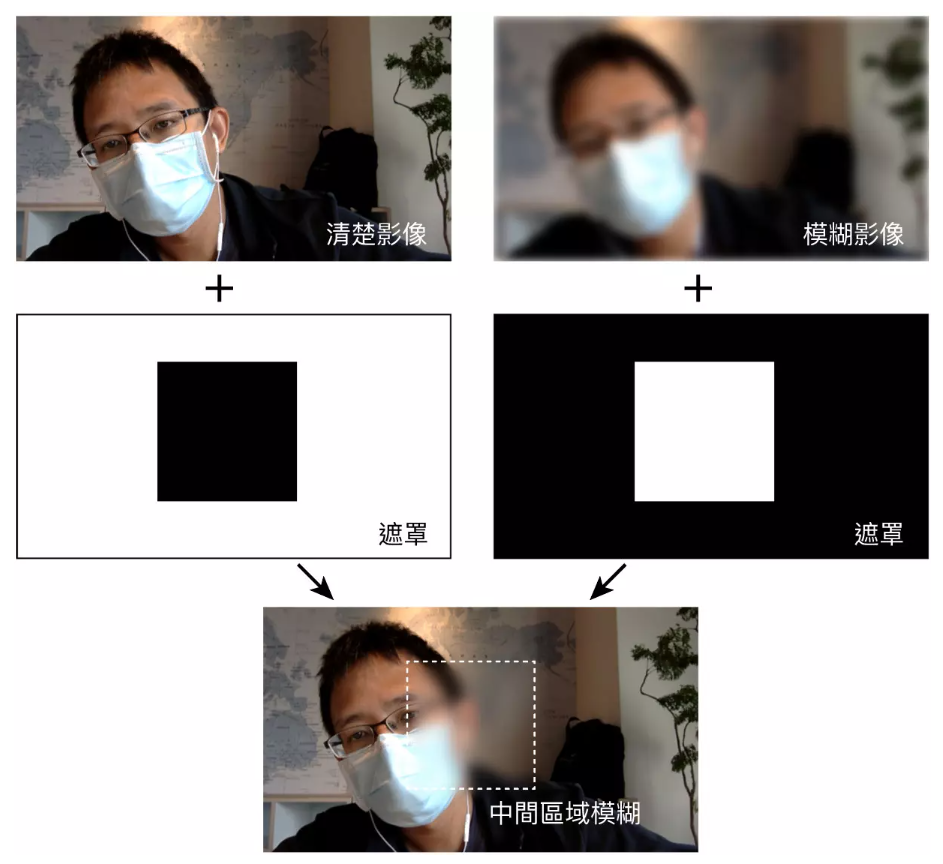

下方的程式碼執行後，會在攝影機的影像中，即時套用遮罩的效果。

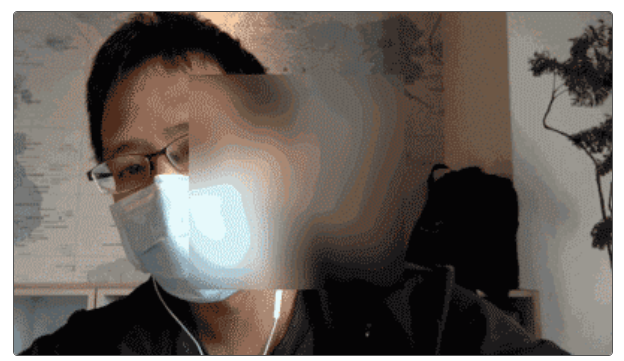

In [1]:
import cv2
import numpy as np

w = 640    # 定義影片寬度
h = 360    # 定義影像高度
dots = []  # 記錄座標

# 產生黑色遮罩 -> 套用清楚影像
mask_b = np.zeros((h, w, 3), dtype='uint8')  # 建立一個全黑的遮罩，大小為 (h, w, 3)
mask_b[:, :] = 255                          # 將遮罩的底色設為白色
mask_b[80:280, 220:420] = 0                 # 將遮罩中 (80, 280) 到 (220, 420) 的區域設為黑色

# 產生白色遮罩 -> 套用模糊影像
mask_w = np.zeros((h, w, 3), dtype='uint8')  # 建立一個全黑的遮罩，大小為 (h, w, 3)
mask_w[80:280, 220:420] = 255               # 將遮罩中 (80, 280) 到 (220, 420) 的區域設為白色

cap = cv2.VideoCapture(0)  # 開啟攝影機

if not cap.isOpened():
    print("Cannot open camera")  # 無法開啟攝影機時，印出錯誤訊息並退出
    exit()

while True:
    ret, img = cap.read()  # 讀取攝影機影像
    if not ret:
        print("Cannot receive frame")  # 無法接收影像時，印出錯誤訊息並跳出迴圈
        break

    img = cv2.resize(img, (w, h))                      # 縮小尺寸，加快速度
    img = cv2.flip(img, 1)                             # 翻轉影像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)        # 轉換顏色為 BGRA ( 計算時需要用到 Alpha 色版 )
    img2 = img.copy()                                  # 複製影像
    img2 = cv2.blur(img, (55, 55))                     # 套用模糊

    mask1 = cv2.cvtColor(mask_b, cv2.COLOR_BGR2GRAY)   # 轉換遮罩為灰階
    img = cv2.bitwise_and(img, img, mask=mask1)        # 清楚影像套用黑遮罩

    mask2 = cv2.cvtColor(mask_w, cv2.COLOR_BGR2GRAY)   # 轉換遮罩為灰階
    img2 = cv2.bitwise_and(img2, img2, mask=mask2)     # 模糊影像套用白遮罩

    output = cv2.add(img, img2)                        # 合併影像

    cv2.imshow('oxxostudio', output)                   # 顯示影像
    if cv2.waitKey(50) == ord('q'):                    # 每 50 毫秒檢查一次是否按下 'q' 鍵，若按下則跳出迴圈
        break

cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗

##### 偵測滑鼠事件，用滑鼠擦除模糊 
了解模糊和清楚合併的原理後，參考「[在影片中即時繪圖](https://steam.oxxostudio.tw/category/python/ai/opencv-video-draw.html)」文章，將滑鼠繪圖的程式加入到程式裡，\
執行後就可以在模糊的影像中，用滑鼠擦出清楚的影像。

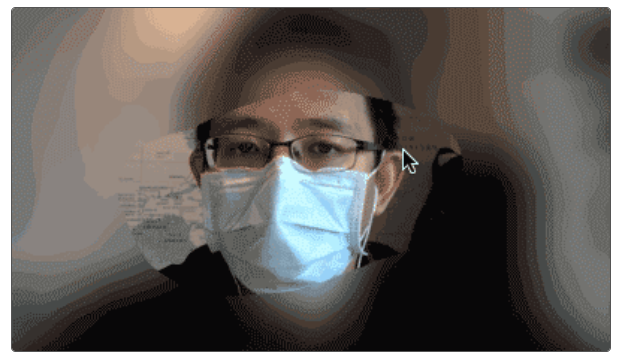

In [2]:
import cv2
import numpy as np

w = 640    # 定義影片寬度
h = 360    # 定義影像高度
dots = []  # 記錄座標

# 產生黑色遮罩 -> 套用清楚影像
mask_b = np.zeros((h, w, 3), dtype='uint8')   

# 產生白色遮罩 -> 套用模糊影像
mask_w = np.zeros((h, w, 3), dtype='uint8')   
mask_w[0:h, 0:w] = 255  # 白色遮罩背景為白色

# 滑鼠繪圖函式
def show_xy(event, x, y, flags, param):
    """
    根據滑鼠事件在遮罩上繪製線條。

    參數:
    event: int - 滑鼠事件類型 (如 cv2.EVENT_LBUTTONDOWN)。
    x: int - 滑鼠的 x 座標。
    y: int - 滑鼠的 y 座標。
    flags: int - 事件發生時的狀態 (如按下的鍵)。
    param: any - 傳遞的參數。
    """
    global dots, mask
    if flags == 1:  # 如果按下滑鼠左鍵
        if event == 1:  # 滑鼠按下事件
            dots.append([x, y])
        if event == 4:  # 滑鼠釋放事件
            dots = []
        if event == 0 or event == 4:  # 滑鼠移動或釋放事件
            dots.append([x, y])
            x1 = dots[len(dots) - 2][0]
            y1 = dots[len(dots) - 2][1]
            x2 = dots[len(dots) - 1][0]
            y2 = dots[len(dots) - 1][1]
            cv2.line(mask_w, (x1, y1), (x2, y2), (0, 0, 0), 50)  # 在白色遮罩上畫出黑色線條
            cv2.line(mask_b, (x1, y1), (x2, y2), (255, 255, 255), 50)  # 在黑色遮罩上畫出白色線條

cv2.imshow('oxxostudio', mask_w)  # 啟用視窗
cv2.setMouseCallback('oxxostudio', show_xy)  # 偵測滑鼠行為

cap = cv2.VideoCapture(0)  # 開啟攝影機

if not cap.isOpened():
    print("Cannot open camera")  # 無法開啟攝影機時，印出錯誤訊息並退出
    exit()

while True:
    ret, img = cap.read()  # 讀取攝影機影像
    if not ret:
        print("Cannot receive frame")  # 無法接收影像時，印出錯誤訊息並跳出迴圈
        break

    img = cv2.resize(img, (w, h))  # 縮小尺寸，加快速度
    img = cv2.flip(img, 1)  # 翻轉影像
    img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)  # 轉換顏色為 BGRA ( 計算時需要用到 Alpha 色版 )
    img2 = img.copy()  # 複製影像
    img2 = cv2.blur(img, (55, 55))  # 套用模糊

    mask1 = cv2.cvtColor(mask_b, cv2.COLOR_BGR2GRAY)  # 轉換遮罩為灰階
    img = cv2.bitwise_and(img, img, mask=mask1)  # 清楚影像套用黑遮罩
    mask2 = cv2.cvtColor(mask_w, cv2.COLOR_BGR2GRAY)  # 轉換遮罩為灰階
    img2 = cv2.bitwise_and(img2, img2, mask=mask2)  # 模糊影像套用白遮罩

    output = cv2.add(img, img2)  # 合併影像

    cv2.imshow('oxxostudio', output)  # 顯示影像
    if cv2.waitKey(50) == ord('q'):  # 每 50 毫秒檢查一次是否按下 'q' 鍵，若按下則跳出迴圈
        break

cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗

##### 偵測手指，用手指擦除模糊 
參考「Mediapipe 手掌偵測」文章，偵測手指的座標，就能透過手指擦除模糊的區域，為了區隔「什麼時候要擦」，\
可以計算「食指和中指的距離」，如果距離比較大就不擦 ( 手勢 YA )，距離比較小就擦 ( 兩隻手指併攏 )。

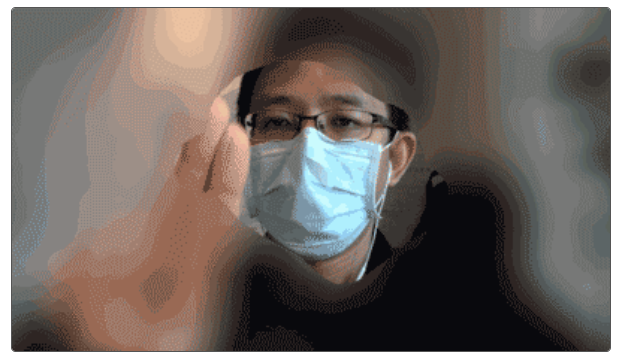

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import math

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0)  # 讀取攝影機

# mediapipe 啟用偵測手掌
with mp_hands.Hands(
    model_complexity=0,  # 模型複雜度，0 為最簡單的模型，適合效能較低的設備
    min_detection_confidence=0.5,  # 最小偵測信心值，範圍為 [0.0, 1.0]
    min_tracking_confidence=0.5  # 最小追蹤信心值，範圍為 [0.0, 1.0]
) as hands:

    if not cap.isOpened():
        print("Cannot open camera")  # 無法開啟攝影機時，印出錯誤訊息並退出
        exit()

    w = 640  # 定義影片寬度
    h = 360  # 定義影像高度
    dots = []  # 記錄座標
    mask_b = np.zeros((h, w, 3), dtype='uint8')  # 產生黑色遮罩 -> 套用清楚影像
    mask_w = np.zeros((h, w, 3), dtype='uint8')  # 產生白色遮罩 -> 套用模糊影像
    mask_w[0:h, 0:w] = 255  # 白色遮罩背景為白色

    while True:
        ret, img = cap.read()  # 讀取攝影機影像
        if not ret:
            print("Cannot receive frame")  # 無法接收影像時，印出錯誤訊息並跳出迴圈
            break

        img = cv2.resize(img, (w, h))  # 縮小尺寸，加快處理效率
        img = cv2.flip(img, 1)  # 翻轉影像
        img_hand = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 偵測手勢使用
        img = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)  # 轉換顏色為 BGRA ( 計算時需要用到 Alpha 色版 )
        img2 = img.copy()  # 複製影像
        img2 = cv2.blur(img, (55, 55))  # 套用模糊

        results = hands.process(img_hand)  # 偵測手勢
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                finger_points = []  # 記錄手指節點位置的串列
                for i in hand_landmarks.landmark:
                    x = i.x
                    y = i.y
                    finger_points.append((x, y))  # 記錄手指節點位置
                if finger_points:
                    fx1 = finger_points[8][0]
                    fy1 = finger_points[8][1]
                    fx2 = finger_points[12][0]
                    fy2 = finger_points[12][1]
                    d = ((fx1 - fx2) ** 2 + (fy1 - fy2) ** 2) ** 0.5  # 計算食指和中指分開的距離
                    if d < 0.15:
                        dots.append([fx1, fy1])
                        dl = len(dots)
                        if dl > 1:
                            x1 = int(dots[dl - 2][0] * w)  # 計算出真正的座標
                            y1 = int(dots[dl - 2][1] * h)
                            x2 = int(dots[dl - 1][0] * w)
                            y2 = int(dots[dl - 1][1] * h)
                            cv2.line(mask_w, (x1, y1), (x2, y2), (0, 0, 0), 50)  # 在白色遮罩上畫出黑色線條
                            cv2.line(mask_b, (x1, y1), (x2, y2), (255, 255, 255), 50)  # 在黑色遮罩上畫出白色線條
                    else:
                        dots = []

        mask1 = cv2.cvtColor(mask_b, cv2.COLOR_BGR2GRAY)  # 轉換遮罩為灰階
        img = cv2.bitwise_and(img, img, mask=mask1)  # 清楚影像套用黑遮罩
        mask2 = cv2.cvtColor(mask_w, cv2.COLOR_BGR2GRAY)  # 轉換遮罩為灰階
        img2 = cv2.bitwise_and(img2, img2, mask=mask2)  # 模糊影像套用白遮罩

        output = cv2.add(img, img2)  # 合併影像

        cv2.imshow('oxxostudio', output)  # 顯示影像
        keyboard = cv2.waitKey(5)  # 每 5 毫秒檢查一次鍵盤輸入
        if keyboard == ord('q'):
            break

cap.release()  # 釋放攝影機資源
cv2.destroyAllWindows()  # 關閉所有 OpenCV 視窗